# Model analisis sentimen ulasan aplikasi Gojek - Diantya Pitaloka.

Melakukan import library yang dibutuhkan untuk keseluruhan proyek.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ABIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ABIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ABIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load dataset

Melakukan read dataset dan menyimpannya di variabel data.

In [8]:
# Read dataset
data = pd.read_csv('ulasan_aplikasi_tokopedia_30K.csv')

Menampilkan lima data teratas dari dataset.

In [9]:
# Menampilkan lima data teratas.
data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a59b8202-6d85-4238-bd7a-3dd49b23fd87,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya pemakai tokopedia sejak lama. saya selalu...,5,141,3.272.0,2024-07-27 08:08:55,"Toppers, terima kasih atas rating yang kamu be...",2024-07-27 08:19:04,3.272.0
1,b3fffbd1-9e79-41a8-bc7a-edca06f1d0c1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saran saya jangan belanja menggunakan kurir re...,5,153,3.273.2,2024-07-28 12:59:32,"Hi Toppers, terima kasih untuk rating dan ulas...",2024-07-28 13:19:25,3.273.2
2,386a4212-7790-49d1-80c1-93a8f8c637e9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sebenernya tokped bagus, banyak promo. Tapi ma...",5,1613,3.267,2024-06-19 03:57:42,"Hi Toppers, terima kasih untuk rating dan ulas...",2024-06-19 04:33:03,3.267
3,a87595ad-c3ad-4b66-8cd3-f1f33ce2b15b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Fitur chatnya toped bikin ribet, masa gak bisa...",5,350,3.267,2024-06-14 08:53:40,"Hi Toppers, terima kasih untuk rating dan ulas...",2024-06-14 09:00:03,3.267
4,a3c66571-dab4-43e3-96d5-c9d83c20b64f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Saya sudah langganan plus, tp kecepatan kurir ...",5,525,3.264,2024-05-24 13:25:36,"Hi Toppers, terima kasih untuk rating dan ulas...",2024-05-24 13:40:02,3.264


Menampilkan lima data terakhir dari dataset.

In [10]:
# Menampilkan lima data terakhir
data.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
29995,f5d8b755-a62f-4870-88dd-6f7532a814ce,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Segala kebutuhan mudah didapatkan di aplikasi ...,5,0,NaN,2021-04-04 02:34:39,NaN,NaN,NaN
29996,a274f2cf-9d91-44e2-b7d2-6b2eef2c7a07,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sangat baik aplikasi nya. Sangat membantu, apa...",5,0,NaN,2020-09-13 10:36:28,NaN,NaN,NaN
29997,7140ddc0-f04a-41d7-974c-536f4ba20975,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya suka belanja di Tokopedia ada gratis ongk...,5,4,3.120,2021-04-15 12:45:17,NaN,NaN,3.120
29998,ef91ad9a-0371-477d-be0f-99d4b9177bff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tokopedia sangat mambantu dalam pemilihan kela...,5,0,3.90,2020-09-16 18:42:40,NaN,NaN,3.90
29999,1883e207-9e97-4f95-a092-8c6ff8b7c1e5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi stabil diseluruh device selama ini, t...",5,0,3.202,2023-01-03 07:53:33,"Toppers, terima kasih atas rating yang kamu be...",2023-01-03 08:41:16,3.202


Menampilkan informasi dari dataset seperti jumlah baris, kolom, dan tipe data.

In [11]:
# Menampilkan info dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  20101 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          7321 non-null   object
 9   repliedAt             7321 non-null   object
 10  appVersion            20101 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


# Data preparation


Menghapus missing value pada kolom content karena hanya kolom inilah yang akan digunakan untuk pelatihan model dan menghapus data yang duplikat.

In [12]:
# Menghapus missing value pada kolom 'content'
clean_data = data.dropna(subset=['content'])

# Menghapus data duplikat
clean_data = clean_data.drop_duplicates()

Menampilkan kembali info dari dataset setelah dilakukan cleaning.

In [13]:
# Menampilkan info dataset
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  20101 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          7321 non-null   object
 9   repliedAt             7321 non-null   object
 10  appVersion            20101 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


Mendefinisikan fungsi-fungsi untuk preprocessing text.

- cleaningText: fungsi untuk menghapus mentions, hastag, RT, link, dan numbers dari text.
- caseFfoldingText: fungsi untuk mengubah text menjadi lowercase.
- tokenizingText: fungsi untuk memecah text menjadi list tokens.
- filteringText: fungsi untuk menghapus stopwords dalam bahasa Indonesia ataupun Inggris.
- stemmingText: fungsi untuk mengubah text menjadi bentuk dasar. Namun pada proyek ini tidak akan digunakan karena proses nya yang lama.
- toSentence: fungsi untuk menggabungkan kembali text yang sebelumnya dipecah menjadi token.

In [14]:
# Mendefinisikan fungsi-fungsi untuk preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

Mendefinisikan fungsi untuk mengubah slangwords menjadi bentuk baku.

In [15]:
# Mendefinisikan fungsi untuk slangwords

slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Mendefinisikan clean_df sebagai dataframe yang sudah bersih.

In [16]:
# Menampilkan dataset yang belum dibersihkan
clean_df = clean_data
clean_df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a59b8202-6d85-4238-bd7a-3dd49b23fd87,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya pemakai tokopedia sejak lama. saya selalu...,5,141,3.272.0,2024-07-27 08:08:55,"Toppers, terima kasih atas rating yang kamu be...",2024-07-27 08:19:04,3.272.0


Menerapkan preprocessing text pada dataset.

In [17]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

Menampilkan dataset setelah

In [18]:
# Menampilkan dataset setelah preprocessing text
clean_df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,a59b8202-6d85-4238-bd7a-3dd49b23fd87,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya pemakai tokopedia sejak lama. saya selalu...,5,141,3.272.0,2024-07-27 08:08:55,"Toppers, terima kasih atas rating yang kamu be...",2024-07-27 08:19:04,3.272.0,saya pemakai tokopedia sejak lama saya selalu ...,saya pemakai tokopedia sejak lama saya selalu ...,saya pemakai tokopedia sejak lama saya selalu ...,"[saya, pemakai, tokopedia, sejak, lama, saya, ...","[pemakai, tokopedia, temukan, penjual, barang,...",pemakai tokopedia temukan penjual barang bagus...


Mengunduh lexicon positive dan negative dari github.

In [20]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])


# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])


Mendefinisikan fungsi untuk menghitung polaritas sentimen.

In [21]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score <= -7):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

## Melakukan pelabelan data

Menghitung polaritas.

In [22]:
# Memberi label pada text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    23393
neutral      4703
negative     1904
Name: count, dtype: int64


# Data understanding

Menampilkan distribusi polarity_score dengan histogram.

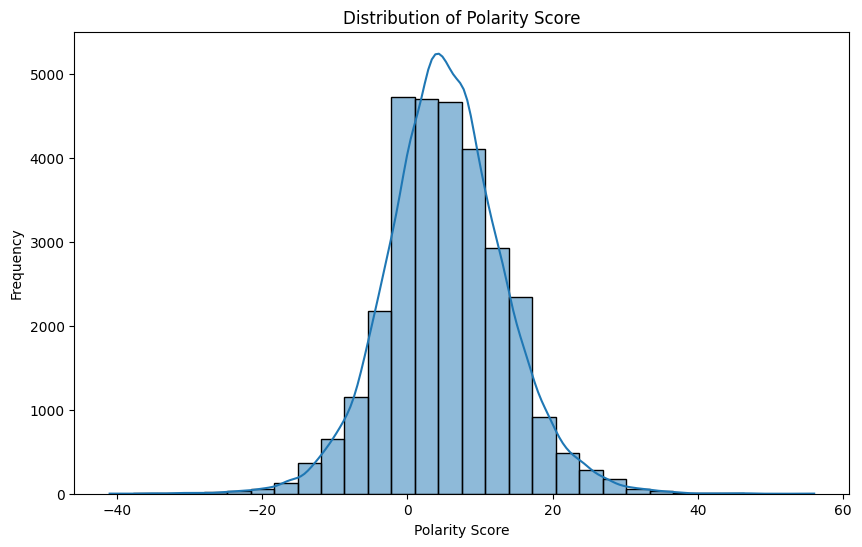

In [23]:
# Menampilkan distribusi polarity_score dengan histogram
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

Menampilkan diagram lingkaran untuk memudahkan visualisasi pembagian dataset.

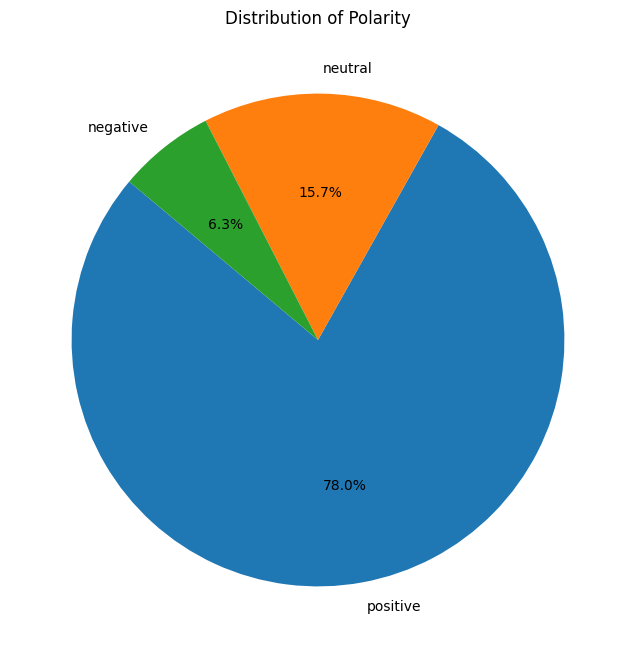

In [24]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()


## Word cloud umum

Membuat wordcloud dari dataset tanpa melihat label.

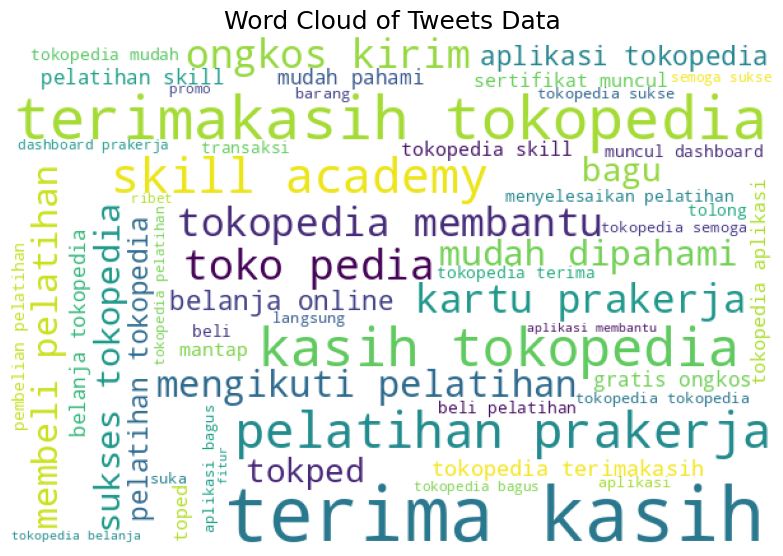

In [25]:
# Membuat wordcloud secara umum

list_words = ''

for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## Word cloud positive

In [26]:
# Membuat dataframe untuk wordcloud positive
pd.set_option('display.max_colwidth', 3000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

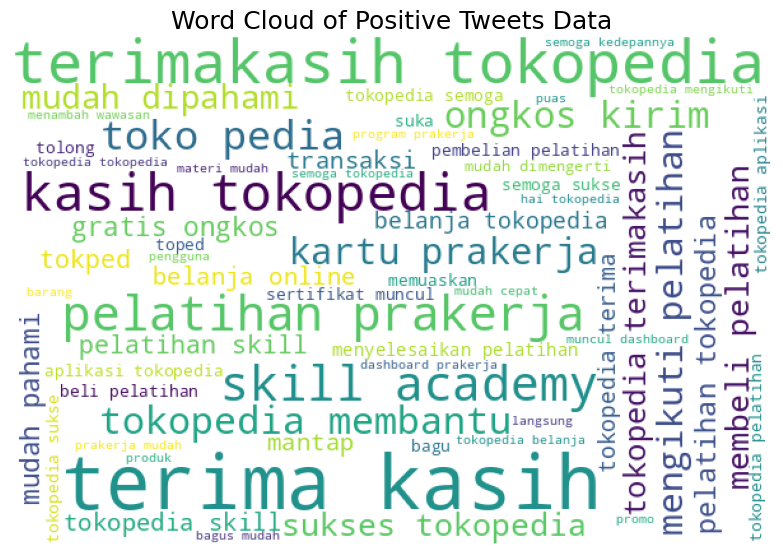

In [27]:
# Menampilkan wordcloud untuk label positive
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

## Word cloud negative

In [28]:
# Membuat dataframe untuk wordcloud negative
pd.set_option('display.max_colwidth', 3000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

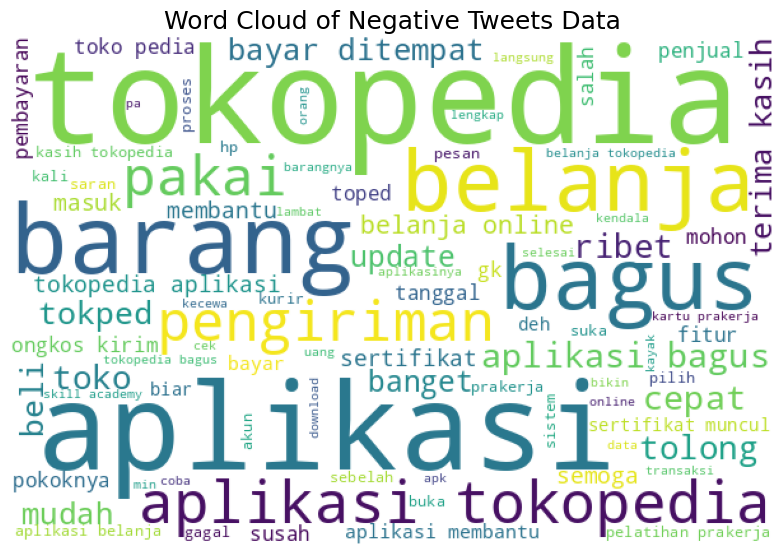

In [29]:
# Menampilkan wordcloud untuk label negative
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

## word cloud neutral

In [30]:
# Membuat dataframe untuk wordcloud neutral
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

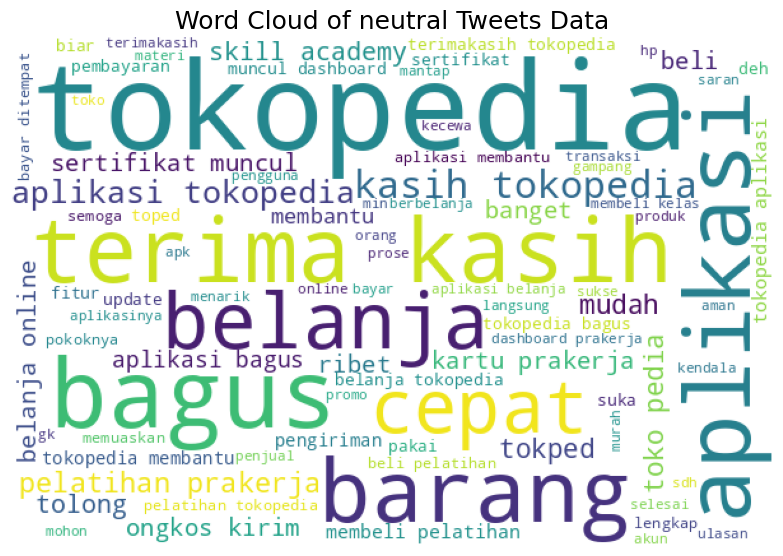

In [31]:
# Menampilkan wordcloud untuk label neutral
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'neutral_tweets'.
for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of neutral Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

## Visualisasi dataset

Menampilkan distribusi dari panjang text.

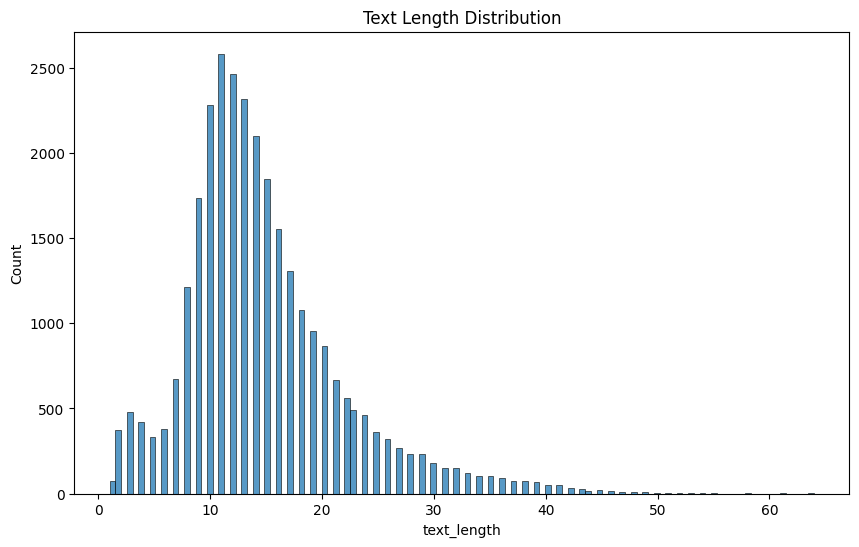

In [32]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

Menampilkan kata yang paling sering muncul.

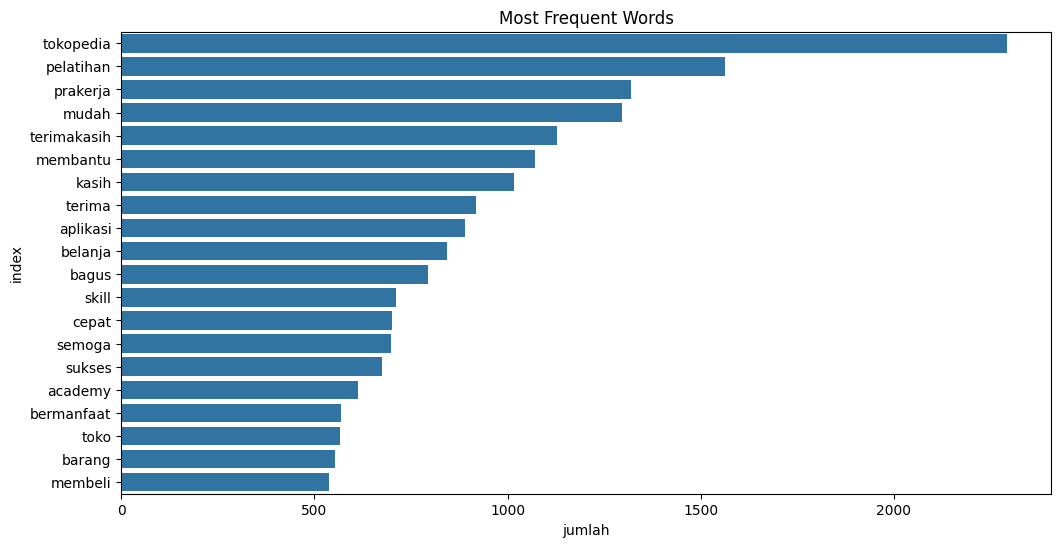

In [33]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

# Modeling

Pembuatan model dengan melakukan tiga percobaan skema pelatihan yang berbeda dan dibedakan dengan variasi dari dua kombinasi seperti berikut:

- Model 1
  - Algoritma Pelatihan: LSTM
  - Pembagian Data: Training 70, val 20, test 10
- Model 2
  - Algoritma Pelatihan: CNN
  - Pembagian Data: Training 80, val 10, test 10
- Model 3
  - Algoritma Pelatihan: GRU
  - Pembagian Data: Training 90, val 5, test 5

Kolom text_akhir dijadikan sebagai fitur dan kolom polarity dijadikan sebagai target.

In [34]:
# Mengambil kolom text_akhir dan polarity
X = clean_df['text_akhir']
y = clean_df['polarity']

Melakukan tokenisasi.

In [36]:
# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

Mendefinisikan callbacks yang akan berhenti jika nilai akurasi pelatihan > 0.95.

In [37]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92:
            print(f"\nVal accuracy telah melebihi 0.92, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True
early_stopping = CustomCallback()

## Model 1 - LSTM

In [38]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

In [39]:
# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_LSTM = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_LSTM, y_val_LSTM))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
11/11 - 13s - 1s/step - accuracy: 0.6997 - loss: 5.3491 - val_accuracy: 0.7795 - val_loss: 4.3517
Epoch 2/50
11/11 - 5s - 443ms/step - accuracy: 0.7801 - loss: 3.8151 - val_accuracy: 0.7795 - val_loss: 3.1812
Epoch 3/50
11/11 - 2s - 226ms/step - accuracy: 0.7801 - loss: 2.8096 - val_accuracy: 0.7795 - val_loss: 2.3587
Epoch 4/50
11/11 - 4s - 361ms/step - accuracy: 0.7801 - loss: 2.0968 - val_accuracy: 0.7795 - val_loss: 1.7858
Epoch 5/50
11/11 - 4s - 335ms/step - accuracy: 0.7801 - loss: 1.6064 - val_accuracy: 0.7795 - val_loss: 1.3918
Epoch 6/50
11/11 - 2s - 195ms/step - accuracy: 0.7801 - loss: 1.2654 - val_accuracy: 0.7795 - val_loss: 1.1021
Epoch 7/50
11/11 - 2s - 196ms/step - accuracy: 0.7802 - loss: 0.9945 - val_accuracy: 0.7817 - val_loss: 0.9066
Epoch 8/50
11/11 - 4s - 407ms/step - accuracy: 0.7949 - loss: 0.7911 - val_accuracy: 0.8027 - val_loss: 0.6905
Epoch 9/50
11/11 - 2s - 200ms/step - accuracy: 0.8216 - loss: 0.6246 - val_accuracy: 0.8292 - val_loss: 0.5593
Epo

In [40]:
# Evaluasi model
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % (score_LSTM))
print("Test accuracy: %.2f" % (acc_LSTM))

94/94 - 3s - 35ms/step - accuracy: 0.9263 - loss: 0.2311
Test score: 0.23
Test accuracy: 0.93


In [41]:
model_LSTM.save('model_LSTM.h5')

## Model 2 - CNN

In [42]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

In [43]:
# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_CNN = model_CNN.fit(X_train_CNN, y_train_CNN, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_CNN, y_val_CNN))


Epoch 1/50
12/12 - 13s - 1s/step - accuracy: 0.7560 - loss: 0.7368 - val_accuracy: 0.7810 - val_loss: 0.6238
Epoch 2/50
12/12 - 1s - 45ms/step - accuracy: 0.7798 - loss: 0.5824 - val_accuracy: 0.7810 - val_loss: 0.5025
Epoch 3/50
12/12 - 1s - 45ms/step - accuracy: 0.7900 - loss: 0.4629 - val_accuracy: 0.8187 - val_loss: 0.3987
Epoch 4/50
12/12 - 1s - 51ms/step - accuracy: 0.8488 - loss: 0.3581 - val_accuracy: 0.8610 - val_loss: 0.3290
Epoch 5/50
12/12 - 1s - 52ms/step - accuracy: 0.8839 - loss: 0.2810 - val_accuracy: 0.8920 - val_loss: 0.2651
Epoch 6/50
12/12 - 1s - 45ms/step - accuracy: 0.9090 - loss: 0.2309 - val_accuracy: 0.9037 - val_loss: 0.2443
Epoch 7/50
12/12 - 1s - 47ms/step - accuracy: 0.9281 - loss: 0.1902 - val_accuracy: 0.9070 - val_loss: 0.2288
Epoch 8/50
12/12 - 1s - 47ms/step - accuracy: 0.9452 - loss: 0.1588 - val_accuracy: 0.9157 - val_loss: 0.2167
Epoch 9/50

Val accuracy telah melebihi 0.92, menghentikan pelatihan pada epoch 9
12/12 - 1s - 47ms/step - accuracy: 0.95

In [44]:
# Evaluasi model
score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2,batch_size=1028)
print("Test score: %.2f" % (score_CNN))
print("Test accuracy: %.2f" % (acc_CNN))

3/3 - 1s - 358ms/step - accuracy: 0.9207 - loss: 0.2175
Test score: 0.22
Test accuracy: 0.92


In [45]:
model_CNN.save('model_CNN.h5')

## Model 3 - GRU

In [46]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.0526, random_state=42)

In [47]:
# Membangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(Bidirectional(GRU(64, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(128, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(num_classes, activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 1028
history_GRU = model_GRU.fit(X_train_GRU, y_train_GRU, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_val_GRU, y_val_GRU),callbacks=[early_stopping])

Epoch 1/20
27/27 - 7s - 259ms/step - accuracy: 0.7473 - loss: 2.7314 - val_accuracy: 0.7920 - val_loss: 1.9596
Epoch 2/20
27/27 - 5s - 169ms/step - accuracy: 0.8239 - loss: 1.5785 - val_accuracy: 0.8773 - val_loss: 1.1642
Epoch 3/20
27/27 - 5s - 188ms/step - accuracy: 0.8875 - loss: 0.9246 - val_accuracy: 0.9060 - val_loss: 0.7361
Epoch 4/20
27/27 - 2s - 92ms/step - accuracy: 0.9241 - loss: 0.5725 - val_accuracy: 0.9107 - val_loss: 0.4953
Epoch 5/20
27/27 - 3s - 94ms/step - accuracy: 0.9398 - loss: 0.3882 - val_accuracy: 0.9193 - val_loss: 0.4009
Epoch 6/20

Val accuracy telah melebihi 0.92, menghentikan pelatihan pada epoch 6
27/27 - 3s - 97ms/step - accuracy: 0.9511 - loss: 0.2792 - val_accuracy: 0.9227 - val_loss: 0.3250


In [48]:
# Evaluasi model
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test score: %.2f" % (score_GRU))
print("Test accuracy: %.2f" % (acc_GRU))

47/47 - 0s - 7ms/step - accuracy: 0.9353 - loss: 0.2829


Test score: 0.28
Test accuracy: 0.94


In [ ]:
# Menyimpan model
model_GRU.save('model_GRU.h5')

## Evaluasi model

In [49]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'GRU'],
    'Accuracy Train': [history_LSTM.history['accuracy'][-1], history_CNN.history['accuracy'][-1],history_GRU.history['accuracy'][-1]],
    'Accuracy Test': [acc_LSTM, acc_CNN,acc_GRU]
})
results_df

,Model,Accuracy Train,Accuracy Test
0,LSTM,0.944952,0.926333
1,CNN,0.953500,0.920667
2,GRU,0.951074,0.935333


# Predict

In [55]:
# Contoh data baru
new_texts = [
    "pemakai tokopedia temukan penjual barang bagus penjual berkualitas original pakaian gadget sparepart sepeda motor sedih fitur kurir rekomendasi gratis ongkos kirim bikin paket layanan berbayar murah gratisan bagus dunia harap tokopedia bikin promo gimmick bikin customer pindah app miss tokopedia",
    "kurir sicepat ganti nama si lambat si lambat tokopedia bagus langganan pke aplikasi tokped bawa nama jelek kurir sicepat min tolong kasih peringatan sicepat nakal kurirnya ngirimnya lambaaaaattttt kali",
    "saran belanja kurir rekomendasi pengirimannya komplain alasannya follow perkembangansaran free ongkos kirim pakai salah kurir kurir kurir"
]

# Nilai asli dari teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi teks baru
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=X.shape[1])

# Membuat prediksi
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = model_GRU.predict(new_padded_sequences)

# Mengubah prediksi menjadi label
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)

# Menampilkan hasil prediksi
for text, true_label, label_LSTM, label_CNN, label_GRU in zip(new_texts, true_labels, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Text: pemakai tokopedia temukan penjual barang bagus penjual berkualitas original pakaian gadget sparepart sepeda motor sedih fitur kurir rekomendasi gratis ongkos kirim bikin paket layanan berbayar murah gratisan bagus dunia harap tokopedia bikin promo gimmick bikin customer pindah app miss tokopedia
True Label: positive
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): positive

Text: kurir sicepat ganti nama si lambat si lambat tokopedia bagus langganan pke aplikasi tokped bawa nama jelek kurir sicepat min tolong kasih peringatan sicepat nakal kurirnya ngirimnya lambaaaaattttt kali
True Label: negative
Predicted Label (LSTM): negative
Predicted Label (CNN): negative
Predicted Label (GRU): negative

Text: saran belanja kurir rekomendasi pengirimannya komplain alasannya follow perkembangansaran free ongkos kirim pakai salah kurir kuri